# Dataset Visualization Notebook

This notebook provides tools to explore and visualize the satellite segmentation dataset. It includes:
- Dataset audit (checking for missing files, data types)
- Single image visualization with RGB, NIR, and mask overlays
- Multi-sample grid visualization
- Class distribution analysis
- Test set visualization

In [ ]:
# ======================
# IMPORTS & CONFIGURATION
# ======================

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tifffile import imread
from collections import Counter
import random

# Dataset paths
DATASET_ROOT = Path("../dataset")
TRAIN_IMAGES_DIR = DATASET_ROOT / "train" / "images"
TRAIN_MASKS_DIR = DATASET_ROOT / "train" / "masks"
TEST_IMAGES_DIR = DATASET_ROOT / "test" / "images"

# Band order in TIFF files: B, G, R, NIR
# Use indices 0..3 to access each band
BAND_ORDER = {"B": 0, "G": 1, "R": 2, "NIR": 3}

# Visualization settings
STRETCH_PCT = (2, 98)           # Percentile stretch for display
OVERLAY_ALPHA = 0.45            # Mask overlay transparency
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

print("Dataset paths configured:")
print("  Train images:", TRAIN_IMAGES_DIR)
print("  Train masks :", TRAIN_MASKS_DIR)
print("  Test images :", TEST_IMAGES_DIR)

## Helper Functions

These utilities handle TIFF reading, array reshaping, and band visualization.

In [ ]:
def read_tiff(path: Path) -> np.ndarray:
    """Read a TIFF file and return as numpy array."""
    return imread(str(path))

def ensure_hwc(arr: np.ndarray) -> np.ndarray:
    """
    Ensure image array is in HWC (Height, Width, Channel) format.
    Converts from CHW if detected.
    """
    if arr.ndim == 3:
        # If shape looks like (C, H, W) where C is small and H, W are large
        if arr.shape[0] in (3, 4, 5, 6) and arr.shape[1] > 32 and arr.shape[2] > 32:
            return np.transpose(arr, (1, 2, 0))
    return arr

def stretch01(x: np.ndarray, p_low=2, p_high=98) -> np.ndarray:
    """
    Percentile stretch to [0, 1] for visualization.
    Helps enhance contrast by stretching values between p_low and p_high percentiles.
    """
    lo, hi = np.percentile(x, (p_low, p_high))
    return np.clip((x - lo) / (hi - lo + 1e-6), 0, 1)

def rgb_from_bgrnir(img_hwc: np.ndarray, band_order=BAND_ORDER, stretch_pct=STRETCH_PCT) -> np.ndarray:
    """
    Extract and stretch RGB bands for visualization.
    Dataset order: B, G, R, NIR (indices 0, 1, 2, 3)
    RGB for display uses R, G, B (indices 2, 1, 0)
    """
    r = img_hwc[..., band_order["R"]].astype(np.float32)
    g = img_hwc[..., band_order["G"]].astype(np.float32)
    b = img_hwc[..., band_order["B"]].astype(np.float32)

    p1, p2 = stretch_pct
    rgb = np.dstack([stretch01(r, p1, p2), stretch01(g, p1, p2), stretch01(b, p1, p2)])
    return rgb

def nir_vis(img_hwc: np.ndarray, band_order=BAND_ORDER, stretch_pct=STRETCH_PCT) -> np.ndarray:
    """Extract and stretch NIR band for visualization."""
    nir = img_hwc[..., band_order["NIR"]].astype(np.float32)
    p1, p2 = stretch_pct
    return stretch01(nir, p1, p2)

## Dataset Audit

Check dataset integrity: count files, identify missing pairs, and inspect data types.

In [ ]:
# ======================
# DATASET AUDIT
# ======================

train_imgs = sorted(TRAIN_IMAGES_DIR.glob("*.tif")) + sorted(TRAIN_IMAGES_DIR.glob("*.tiff"))
train_msks = sorted(TRAIN_MASKS_DIR.glob("*.tif")) + sorted(TRAIN_MASKS_DIR.glob("*.tiff"))

print(f"Dataset summary:")
print(f"  Train images: {len(train_imgs)}")
print(f"  Train masks : {len(train_msks)}")

# Check for orphaned files
img_names = {p.name for p in train_imgs}
msk_names = {p.name for p in train_msks}

missing_masks = sorted(img_names - msk_names)[:10]
missing_imgs = sorted(msk_names - img_names)[:10]

if missing_masks:
    print(f"  ⚠ Images without masks (first 10): {missing_masks}")
if missing_imgs:
    print(f"  ⚠ Masks without images (first 10): {missing_imgs}")
if not missing_masks and not missing_imgs:
    print(f"  ✓ All files have matching pairs")

# Inspect example file
if train_imgs:
    x = ensure_hwc(read_tiff(train_imgs[0]))
    y = read_tiff(TRAIN_MASKS_DIR / train_imgs[0].name)
    print(f"\nExample file: {train_imgs[0].name}")
    print(f"  Image shape: {x.shape}, dtype: {x.dtype}")
    print(f"  Mask shape : {y.shape}, dtype: {y.dtype}")
    print(f"  Mask classes (sample): {np.unique(y)[:20]}")

## Single Image Visualization

Visualize one image with RGB, NIR bands and mask overlay.

In [ ]:
def visualize_one(filename: str = None, index: int = 0,
                  images_dir: Path = TRAIN_IMAGES_DIR, masks_dir: Path = TRAIN_MASKS_DIR,
                  band_order=BAND_ORDER, stretch_pct=STRETCH_PCT,
                  overlay_alpha=OVERLAY_ALPHA):
    """
    Visualize a single image/mask pair.
    
    Parameters:
      - filename: specific file to load (e.g., "1.tif")
      - index: file index from sorted list (if filename is None)
      - images_dir, masks_dir: paths to data directories
      - overlay_alpha: transparency for mask overlay
    """
    img_files = sorted(images_dir.glob("*.tif")) + sorted(images_dir.glob("*.tiff"))
    if not img_files:
        raise FileNotFoundError(f"No TIFF files found in {images_dir}")

    if filename is None:
        img_path = img_files[index]
    else:
        img_path = images_dir / filename
        if not img_path.exists():
            raise FileNotFoundError(f"File not found: {img_path}")

    mask_path = masks_dir / img_path.name
    if not mask_path.exists():
        raise FileNotFoundError(f"Mask not found: expected {mask_path}")

    # Load and preprocess
    img = ensure_hwc(read_tiff(img_path))
    msk = read_tiff(mask_path)
    rgb = rgb_from_bgrnir(img, band_order=band_order, stretch_pct=stretch_pct)
    nir = nir_vis(img, band_order=band_order, stretch_pct=stretch_pct)

    # Visualize
    fig, axes = plt.subplots(1, 4, figsize=(14, 4))
    
    axes[0].imshow(rgb)
    axes[0].set_title(f"RGB: {img_path.name}")
    axes[0].axis("off")
    
    axes[1].imshow(nir, cmap="gray")
    axes[1].set_title("NIR Band")
    axes[1].axis("off")
    
    axes[2].imshow(msk)
    axes[2].set_title("Ground Truth Mask")
    axes[2].axis("off")
    
    axes[3].imshow(rgb)
    axes[3].imshow(msk, alpha=overlay_alpha)
    axes[3].set_title("Overlay (Mask on RGB)")
    axes[3].axis("off")
    
    plt.tight_layout()
    plt.show()

    print(f"Loaded: {img_path.name}")
    print(f"  Image: {img.shape} {img.dtype} | Mask: {msk.shape} {msk.dtype}")
    print(f"  Classes: {np.unique(msk)}")

# Choose: visualize_one(index=0) OR visualize_one(filename="1.tif")
visualize_one(filename="1.tif")

## Grid Visualization

View multiple random samples side-by-side for quick dataset exploration.

In [ ]:
def visualize_grid(k=6, images_dir=TRAIN_IMAGES_DIR, masks_dir=TRAIN_MASKS_DIR,
                   band_order=BAND_ORDER, stretch_pct=STRETCH_PCT, overlay_alpha=OVERLAY_ALPHA):
    """
    Visualize k random samples in a grid (3 columns per sample: RGB, Mask, Overlay).
    
    Parameters:
      - k: number of samples to display
    """
    img_files = sorted(images_dir.glob("*.tif")) + sorted(images_dir.glob("*.tiff"))
    if not img_files:
        raise FileNotFoundError(f"No TIFF files found in {images_dir}")

    k = min(k, len(img_files))
    sample = random.sample(img_files, k)

    fig, axes = plt.subplots(k, 3, figsize=(12, 2 * k))
    if k == 1:
        axes = axes.reshape(1, -1)

    for i, img_path in enumerate(sample):
        mask_path = masks_dir / img_path.name
        img = ensure_hwc(read_tiff(img_path))
        rgb = rgb_from_bgrnir(img, band_order=band_order, stretch_pct=stretch_pct)
        msk = read_tiff(mask_path) if mask_path.exists() else None

        # RGB
        axes[i, 0].imshow(rgb)
        axes[i, 0].set_title(f"RGB: {img_path.stem}")
        axes[i, 0].axis("off")

        # Mask
        axes[i, 1].set_title("Mask" if msk is not None else "Mask (missing)")
        if msk is not None:
            axes[i, 1].imshow(msk)
        axes[i, 1].axis("off")

        # Overlay
        axes[i, 2].imshow(rgb)
        if msk is not None:
            axes[i, 2].imshow(msk, alpha=overlay_alpha)
        axes[i, 2].set_title("Overlay")
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()

# Display 6 random samples
visualize_grid(k=6)

## Class Distribution Analysis

Count pixel frequencies for each class to understand dataset balance.

In [ ]:
def class_distribution(masks_dir=TRAIN_MASKS_DIR, max_masks=None):
    """
    Analyze pixel distribution across classes in training masks.
    
    Parameters:
      - max_masks: limit analysis to first N masks (for speed)
    """
    mask_files = sorted(masks_dir.glob("*.tif")) + sorted(masks_dir.glob("*.tiff"))
    if not mask_files:
        raise FileNotFoundError(f"No mask TIFF files found in {masks_dir}")

    if max_masks is not None:
        mask_files = mask_files[:max_masks]

    cnt = Counter()
    total = 0

    for p in mask_files:
        m = read_tiff(p)
        vals, freqs = np.unique(m, return_counts=True)
        for v, f in zip(vals, freqs):
            cnt[int(v)] += int(f)
            total += int(f)

    # Print table
    print("Class pixel distribution:")
    print(f"{'Class':<6} {'Pixels':<15} {'Percentage':<10}")
    print("-" * 31)
    for k in sorted(cnt):
        pct = 100 * cnt[k] / total
        print(f"{k:<6} {cnt[k]:<15} {pct:>8.2f}%")

    # Bar plot
    keys = sorted(cnt.keys())
    freqs = [cnt[k] for k in keys]

    plt.figure(figsize=(10, 4))
    plt.bar([str(k) for k in keys], freqs)
    plt.title("Pixel count per class (training masks)")
    plt.xlabel("Class label")
    plt.ylabel("Pixel count")
    plt.yscale("log")
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

# Analyze class distribution
class_distribution()

## Test Set Visualization

View test images (without ground truth masks if unavailable).

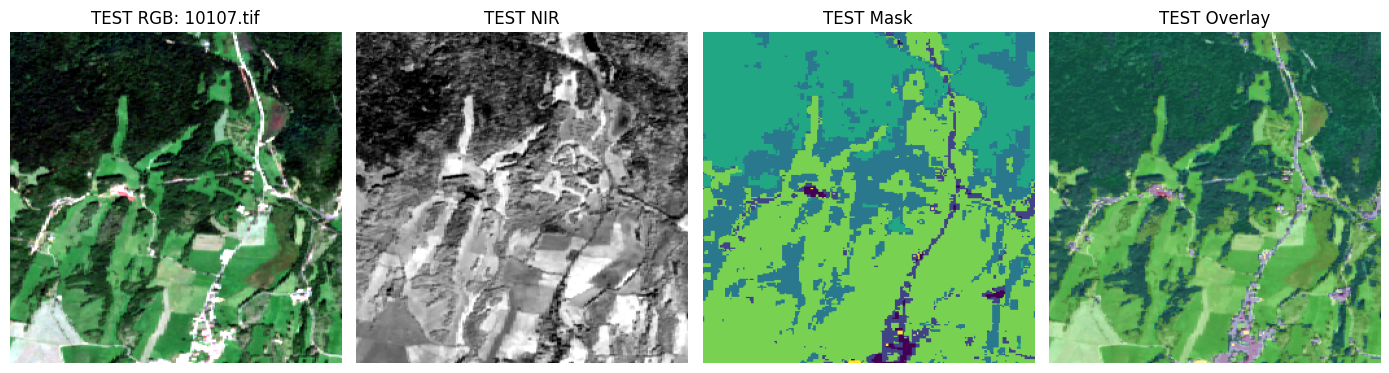

✓ Test masks directory exists. Mask shape: (256, 256), unique labels: [2 3 4 5 6 7]


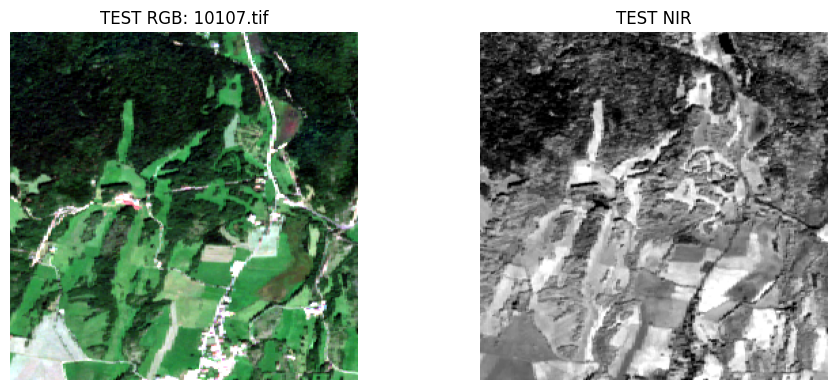

In [ ]:
def visualize_test_one(filename: str = None, index: int = 0,
                       images_dir: Path = TEST_IMAGES_DIR,
                       band_order=BAND_ORDER, stretch_pct=STRETCH_PCT):
    """
    Visualize a test image (may or may not have ground truth mask).
    
    Parameters:
      - filename: specific file to load
      - index: file index from sorted list
    """
    img_files = sorted(images_dir.glob("*.tif")) + sorted(images_dir.glob("*.tiff"))
    if not img_files:
        raise FileNotFoundError(f"No TIFF files found in {images_dir}")

    if filename is None:
        img_path = img_files[index]
    else:
        img_path = images_dir / filename
        if not img_path.exists():
            raise FileNotFoundError(f"File not found: {img_path}")

    img = ensure_hwc(read_tiff(img_path))
    rgb = rgb_from_bgrnir(img, band_order=band_order, stretch_pct=stretch_pct)
    nir = nir_vis(img, band_order=band_order, stretch_pct=stretch_pct)

    # Check if test masks exist
    test_masks_dir = DATASET_ROOT / "test" / "masks"
    mask_path = test_masks_dir / img_path.name
    has_mask = mask_path.exists()

    if has_mask:
        msk = read_tiff(mask_path)
        fig, axes = plt.subplots(1, 4, figsize=(14, 4))
        
        axes[0].imshow(rgb)
        axes[0].set_title(f"Test RGB: {img_path.name}")
        axes[0].axis("off")
        
        axes[1].imshow(nir, cmap="gray")
        axes[1].set_title("Test NIR")
        axes[1].axis("off")
        
        axes[2].imshow(msk)
        axes[2].set_title("Test Mask")
        axes[2].axis("off")
        
        axes[3].imshow(rgb)
        axes[3].imshow(msk, alpha=OVERLAY_ALPHA)
        axes[3].set_title("Overlay")
        axes[3].axis("off")
        
        plt.tight_layout()
        plt.show()
        print(f"✓ Test file with mask: {img_path.name}")
        print(f"  Mask shape: {msk.shape}, Classes: {np.unique(msk)}")
    else:
        # Only show RGB and NIR
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        
        axes[0].imshow(rgb)
        axes[0].set_title(f"Test RGB: {img_path.name}")
        axes[0].axis("off")
        
        axes[1].imshow(nir, cmap="gray")
        axes[1].set_title("Test NIR")
        axes[1].axis("off")
        
        plt.tight_layout()
        plt.show()
        print(f"⚠ Test file (no mask directory): {img_path.name}")

    print(f"  Image shape: {img.shape}, dtype: {img.dtype}")

# Visualize test image (change index or filename as needed)
visualize_test_one(index=0)